# ECE 117 - Assignment 3: Part 2
The goal of this part of the assignment is to implement the adversarial examples attack, FGSM.

In [1]:
import numpy as np
import torch
from torch import nn, utils
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# load CIFAR-10, which is proposed by Alex Krizhevsky and Geoffrey Hinton
# it contains 60,000 32x32 images (50,000 for training, 10,000 for testing)
# CIFAR-10 divides these images to 10 categories

transform = transforms.Compose([transforms.ToTensor()]) # covert data in CIFAR-10 to tensors

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:17<00:00, 10.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# there are 10 categories in CIFAR-10

classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [5]:
# construct our Neural Network

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 10))

    def forward(self, x):
        x = self.network(x)
        return x

    def size(self):
        parameters = self.parameters()
        size = 0
        for parameter in parameters:
            size += np.prod(parameter.shape)
        return size

In [6]:
# Download a pretrained CIFAR-10 model (we don't have to pre-train a model to perform on CIFAR-10 in this task)
!pip install wget
import wget

weights_file = wget.download("https://github.com/kuanhenglin/ai-security-workshop/blob/f08ced8a4afb7de1120bfdbf468888c7be10fdd8/cifar10_model.pth?raw=true")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=07bb8939753ab98294fbc832d7a829eff33273019cfbaba89637fc35cf3d2c20
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [7]:
network = CNN()
network.load_state_dict(torch.load(weights_file, map_location=device))
network.to(device)
network.eval() # show the model architecture

<ipython-input-7-1ea5b2f7a6ee>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(weights_file, map_location=device))


CNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), paddi

In [8]:
# test the performance on test datasets with the pre-trained model

@torch.no_grad()
def evaluate(loader, network):
    network.eval()
    accuracies = []
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = network(inputs)
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()  # accuracy
        accuracies.append(accuracy.cpu().numpy())
    return np.mean(accuracies)

In [9]:
accuracy = evaluate(test_loader, network)
print(f"Test accuracy: {str(accuracy * 100):.6}%")

Test accuracy: 86.797%


## Adversarial Attack

In this task, you need to implement an Adversarial Attack to mislead the model to precit images incorrectly

In [10]:
# a util function to display the images

def display_torch_image(image, label=None):
    if label is not None:
        plt.title(f"{classes[label]} ({label})")
    plt.axis("off")
    plt.imshow(torch.moveaxis(image, 0, -1).cpu(), vmin=0, vmax=1)

In [11]:
def display_attacked(image, image_attacked, noise, label, label_attacked):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].axis("off")
    axes[0].set_title(f"{classes[label]} ({label})", fontsize=16)
    axes[0].text(33.25, 16.5, "$+$", fontsize=24)
    axes[0].imshow(torch.moveaxis(image, 0, -1).cpu(), vmin=0, vmax=1)

    axes[1].axis("off")
    axes[1].set_title(f"noise (amplified 5x)", fontsize=16)
    axes[1].text(32.75, 16, "$=$", fontsize=24)
    axes[1].imshow(torch.moveaxis(noise, 0, -1).cpu(), vmin=0, vmax=1)

    axes[2].axis("off")
    axes[2].set_title(f"{classes[label_attacked]} ({label_attacked})", fontsize=16)
    axes[2].imshow(torch.moveaxis(image_attacked, 0, -1).cpu(), vmin=0, vmax=1)

In [21]:
def adversarial_attack(network, image, label, epsilon=0.1, sign=True):
    # TODO

    # Your implementation here.
    # the idea is from Fast-Gradient Sign Method, where we perform gradient ascent
    # we find the gradient of the loss with respect to the images
    # then we nudge it with sign(g)
    # refer to our lab3 slides

    # forward pass
    image.requires_grad = True

    # pass image through network to get output
    output = network(image.unsqueeze(dim=0))[0]
    prediction = output.max(dim=0)[1].cpu().numpy()
    loss = F.nll_loss(output, label)

    #gradients of loss with respect to the image
    image_gradients = torch.autograd.grad(loss, image)[0]
    if sign:
      image_gradients = image_gradients.sign()

    #fast gradient sign attack

    #add noise to image
    image_attacked = (image + epsilon * image_gradients).clamp(0,1)

    #get model output of attacked
    output_attacked = network(image_attacked.unsqueeze(dim=0))[0]

    #get prediction
    prediction_attacked = output_attacked.max(dim=0)[1].cpu().numpy()

    # End of TODO

    display_attacked(image.detach(), image_attacked.detach(),
                     image_gradients.detach() * 0.5 * (5 * epsilon) + 0.5,
                     label=prediction, label_attacked=prediction_attacked)

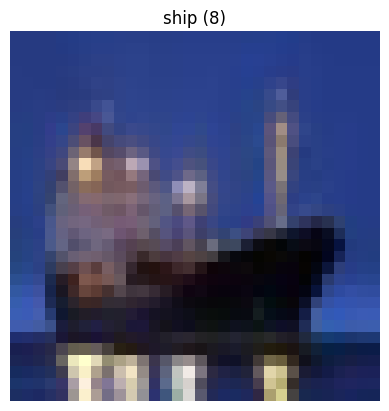

In [27]:
batch_data = next(iter(train_loader))
image = batch_data[0][0].to(device)
label = batch_data[1][0].to(device)
with torch.no_grad():
    prediction = network(image.unsqueeze(dim=0)).max(dim=1)[1][0].cpu().numpy()
    display_torch_image(image, label=prediction)

### Fast Gradient Sign Attack (FGSM)

The goal of this part is to demonstrate a misclasification a baseline epsilon is provided but your goal is to provide the best hyperparameter.

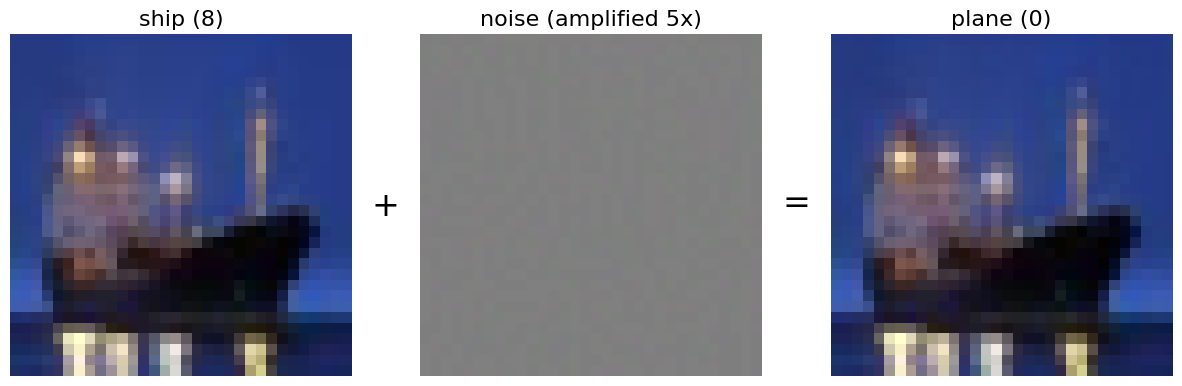

In [35]:
adversarial_attack(network, image, label, epsilon=0.002, sign=True)